In [6]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import corpus
import math
import time

"""
Implementation of: http://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf

'n-1' words are feeded to network, output is the probability of the each of the word in dictionary. 
The aim of the network is to maximize the probablitlity of the target word.
Each word in dictionary will be encoded by number, which will then be converted into one-hot vector.
Collection of these one hot vectors will be used to form an input matrix of size (n-1)x|V|. This 
matrix will be multiplied by a matrix C of size |V|x m where m is the number of features, |V| is 
the number of words in dictionary. C(i) represents the feature vector of word being encoded by 
number i. Hence, output of above will represent the feature vector in (n-1) x m  matrix. We will 
concatenate the rows to form a vector 'x' containing the feature vectors in order of size (n-1)m x 1.
Note: any other way will be equally good to extract needed rows from C and put them in order given.
This will be feeded to a hidden layer containg h neruons with tan-sigmoid as the activation 
function. Output will be a h x 1 matrix (tanh(Hx + d)). We will feed y = b + Wx + U(tanh(Hx + d))
to the softmax function in final layer to get the probabilites of the words being the target word.
b is the bias matrix for softmax layer having size |V| x 1, W is the feature-to-output weight 
matrix with size |V| x (n-1)m (can be set to zero permanently), U is the hidden-to-output weight 
matrix with size |V| x h. 

Input Preprocessing:
	Convert the word to encoded numbers and then to one-hot vector matrix.
	Variables needed:
		let there be k input-target pairs presented sub-array of words from corpus, size: [k, n-1]
		target word for given sub-array, string
		dictionary containing words to code numbering
	Operations:
		form the array of numbers from given sub_array of words using dictionary
		form the matrix 'hot_matrix' with rows as one-hot vectors of words, size: [n-1, |V|]

First Layer:
	Convert one-hot vectors to feature-vector matrix 'x'. 
	Variables needed:
		matrix C containg the feature vectors of all the words
	Operations:
		compute the product of hot_matrix and C (size: [n-1, m])
		ravel (and transpose) the matrix to form x (size: [k, (n-1)m])  

Second Layer:
	Sigmoid layer outputs tanh(Hx+d).
	Variables needed:
		weight matrix H (size: [h, (n-1)m]) for x and biases d (size: [h])
	Operations:
		Compute the output tanh(Hx+d) (size: [k, h])

Third Layer:
	Softmax layer outputs softmax of y = b + Wx + U(tanh(Hx+d)).
	Variables needed:
		b is the bias matrix of size: |V| x 1 
		W is the feature-to-output matrix (can be deleted optionally) of size: |V| x (n-1)m
		U is the hidden-to-output matrix of size: |V| x h
	Operations:
		compute softmax of y = b + Wx + U(h2) where h2 is the output from previous layer

Loss: 
	Use the log-likelihood with regularization (regularization not implemented yet.)
"""

"\nImplementation of: http://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf\n\n'n-1' words are feeded to network, output is the probability of the each of the word in dictionary. \nThe aim of the network is to maximize the probablitlity of the target word.\nEach word in dictionary will be encoded by number, which will then be converted into one-hot vector.\nCollection of these one hot vectors will be used to form an input matrix of size (n-1)x|V|. This \nmatrix will be multiplied by a matrix C of size |V|x m where m is the number of features, |V| is \nthe number of words in dictionary. C(i) represents the feature vector of word being encoded by \nnumber i. Hence, output of above will represent the feature vector in (n-1) x m  matrix. We will \nconcatenate the rows to form a vector 'x' containing the feature vectors in order of size (n-1)m x 1.\nNote: any other way will be equally good to extract needed rows from C and put them in order given.\nThis will be feeded to a hidden layer

In [7]:
def make_corpus(fileName):
	word_array, dictionary = corpus.dictionary('text8', 1)
	codes = corpus.code_dictionary(dictionary)
	return word_array, codes

def make_placeholders(k, n, V):
	input_placeholder = tf.placeholder(tf.float32, shape = (k, n-1, V))
	labels_placeholder = tf.placeholder(tf.int32, shape = (k))
	return input_placeholder, labels_placeholder

def fill_feed_dict(k, n, V, coded_word_array, input_placeholder, labels_placeholder):
	""" Outputs the feed_dict given the array of n words where last word will be used as target word.
	Args:
		k: batch size of the input
		n: number of words used in an input, first n-1 are input and last is target word
		V: size of the vocabulary being used
		coded_word_array: is a k x n matrix containing codes of the words
		input_placeholder: input placeholder
		target_placeholder: output placeholder
	Returns:
		feed_dict: dictionary filled with input_placeholder and target_placeholder
	"""
	input_to_net = np.zeros((k, n-1, V))
	labels = np.zeros(k)
	for input_number in range(len(coded_word_array)):
		# INPUT ARRAY
		for word_number in range(len(coded_word_array[input_number])-1):
			word_code = coded_word_array[input_number][word_number]
			input_to_net[input_number][word_number][word_code] = 1
		# TARGET ARRAY
		word_code = coded_word_array[input_number][-1]
		labels[input_number] = word_code
	feed_dict = {input_placeholder: input_to_net, labels_placeholder: labels}
	return feed_dict

def inference(input_to_net, k, n, m, h, V):
	""" Calculate the output from given input
	Args:
		input_placeholder: input placeholder
		k: batch size
		n: number of words used
		m: number of features
		h: number of neurons in hidden layer
		V: vocabulary size
	Returns:
		logits: the logits output of final layer
	"""
	# LAYER ONE
	with tf.name_scope('feature'):
		feature_matrix = tf.Variable(
				tf.truncated_normal([V, m], 
				stddev = 1.0/math.sqrt(float(V))), 
			name = 'feature_matrix')
		feature = tf.matmul(tf.reshape(input_to_net, (k*(n-1), V)), feature_matrix)
		feature = tf.reshape(feature, (k, (n-1) * m), name = 'feature')

	# LAYER TWO
	with tf.name_scope('hidden'):
		weights = tf.Variable(
			tf.truncated_normal(
				[(n-1)*m, h],
				stddev = 1.0/math.sqrt((n-1)*m)),
			name = 'weights')
		biases = tf.Variable(
			tf.zeros([h]),
			name = 'biases')
		hidden = tf.tanh(tf.matmul(feature, weights) + biases)

	# LAYER THREE
	with tf.name_scope('logits'):
		hidden_to_output_weights = tf.Variable(
			tf.truncated_normal([h, V], 
				stddev = 1.0/math.sqrt(h)),
			name = 'hidden_to_output_weights')
		biases = tf.Variable(tf.zeros([V]), 
			name = 'biases')
		logits = tf.matmul(hidden, hidden_to_output_weights) + biases
	return logits

def loss(logits, labels): # WITHOUT REGULARIZATION
	""" Calculate the loss fron target_outputs and softmax
	Args:
		logits: logits tensor, float - [k, V]
		labels: labels tensor, int32 - [k] with values in range [0, V)
	Returns:
		loss: the loss calculated from given arguments
	"""
	cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits, 
		labels,
		name = 'xentropy')
	loss =  tf.reduce_mean(cross_entropy, 
		name = 'xentropy_mean') 
	return loss

def train(loss, learning_rate):
	""" Sets up training ops
	Create a summarizer to keep track of loss over time in TensorBoard
	Create an optimizer and applies the gradients to all trainable variables
	Args:
		loss: the loss tensor
		learning_rate: learning rate for training
	"""
	tf.summary.scalar('loss', loss)
	optimizer = tf.train.GradientDescentOptimizer(learning_rate)
	global_step = tf.Variable(0, name = 'global_step', trainable = False)
	train_op = optimizer.minimize(loss)
	return train_op

def evaluation(logits, labels):
	""" Evaluate the quality of the logits at predicting the target
	Args:
		logits: logits tensor, float - [k, V]
		labels: labels tensor, int32 - [k] with values in the range [0, V)
	Returns:
		A scalar int32 tensor with the number of examples (out of k) that 
			were predicted correctly.
	"""
	correct = tf.nn.in_top_k(logits, labels, 1)
	return tf.reduce_sum(tf.cast(correct, tf.int32))

def make_coded_word_array(k, n, start, word_array, codes):
	coded_word_array = np.zeros((k, n), dtype = int)
	for j in range(k):
		if start+j+n <= len(word_array):
			coded_word_array[j] = coded_word_array[j] + corpus.coded_array(
				word_array[start+j:start+j+n], codes)
	return coded_word_array

def do_eval(k, n, V, codes,
	sess, eval_correct, input_placeholder, labels_placeholder, word_array):
	""" Runs one evaluation against the full epoch of data:
	Args:
		sess: the session in which the model has been trained
		eval_correct: the tensor that returns number of correct predictions
		input_placeholder: the input placeholder
		labels_placeholder: the labels placeholder
		word_array: the set on which to evaluate the model
	"""
	num_examples = len(word_array) - n + 1
	batch_size = k
	true_count = 0
	steps_per_epoch = num_examples // batch_size
	num_examples = steps_per_epoch * batch_size
	for step in range(steps_per_epoch):
		coded_word_array = make_coded_word_array(k, n, step*batch_size, 
			word_array, codes)
		feed_dict = fill_feed_dict(k, n, V, 
			coded_word_array, 
			input_placeholder, 
			labels_placeholder)
		true_count += sess.run(eval_correct, feed_dict)
	precision = float(true_count)/num_examples
	print('Number of examples: %d Number of correct: %d Precision @ 1: %f'
		% (num_examples, true_count, precision))
	return precision

### First Successful Run (with 10000 words in corpus)

3 words

10 batch size

300 features

10000 word corpus with 2520 unique words

800 neurons in hidden layer

0.05 learning rate

50 iterations

In [8]:
k = 10 # batch size
n = 3 # Number of word looked up in corpus at one time
m = 300 # Number of features
h = 800 # Number of neurons in hidden layer 
learning_rate = 0.05
training_word_array, codes = make_corpus("text8")
validation_word_array = corpus.corpus_word_array("text9")
testing_word_array = corpus.corpus_word_array("text10")
corpus_length = len(training_word_array)
V = len(codes) # The size of vocabulary

There are 10000 words in corpus.
Size of dictionary: 2520
Number of words occuring more than minimum freuqecy: 2520
Percentage covered by top words: 100.0


In [9]:
precision_history_on_training = []
precision_history_on_validation = []
precision_history_on_testing = []

with tf.Graph().as_default():
    input_placeholder, labels_placeholder = make_placeholders(k, n, V)
    logits = inference(input_placeholder, k, n, m, h, V)
    loss_op = loss(logits, labels_placeholder)
    train_op = train(loss_op, learning_rate)
    eval_correct = evaluation(logits, labels_placeholder)
    summary = tf.summary.merge_all()
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()
    sess = tf.Session()
    sess.run(init)
    # summary_writer = tf.summary.FileWriter('model.ckpt', sess.graph)

    # TRAINING
    num_of_epoch = 50
    for epoch_num in range(num_of_epoch):
        for start in range(0, corpus_length-n+1, k):
            start_time = time.time()
            coded_word_array = make_coded_word_array(k, n, start, training_word_array, codes)
            feed_dict = fill_feed_dict(k, n, V, 
                coded_word_array, 
                input_placeholder, 
                labels_placeholder)
            _, loss_value = sess.run([train_op, loss_op], feed_dict)

            if start % 200 == 0:
                print("Epoch: %d Step: %d - Loss value: %f Time taken (s): %f" 
                    % (epoch_num, start, loss_value, time.time()-start_time))
                # summary_str = sess.run(summary, feed_dict = feed_dict)
                # summary_writer.add_summary(summary_str, step)
                # summary_writer.flush()

            if start % 2500 == 0:
                # checkpoint_file = 'model.ckpt'
                # saver.save(sess, checkpoint_file, global_step = step)
                print("Training data eval:")
                precision_history_on_training.append(do_eval(k, n, V, codes,
                                                             sess,
                                                             eval_correct, 
                                                             input_placeholder,
                                                             labels_placeholder,
                                                             training_word_array))
                print("Validation data eval:")
                precision_history_on_validation.append(do_eval(k, n, V, codes,
                                                             sess,
                                                             eval_correct, 
                                                             input_placeholder,
                                                             labels_placeholder,
                                                             validation_word_array))
                print("Testing data eval:")
                precision_history_on_testing.append(do_eval(k, n, V, codes,
                                                             sess,
                                                             eval_correct, 
                                                             input_placeholder,
                                                             labels_placeholder,
                                                             testing_word_array))


print("Network taining complete.")

Epoch: 0 Step: 0 - Loss value: 7.828715 Time taken (s): 0.032350
Training data eval:
Number of examples: 9990 Number of correct: 5 Precision @ 1: 0.000501
Validation data eval:
Number of examples: 490 Number of correct: 0 Precision @ 1: 0.000000
Testing data eval:
Number of examples: 490 Number of correct: 1 Precision @ 1: 0.002041
Epoch: 0 Step: 200 - Loss value: 7.831854 Time taken (s): 0.038852
Epoch: 0 Step: 400 - Loss value: 7.797075 Time taken (s): 0.037588
Epoch: 0 Step: 600 - Loss value: 7.771674 Time taken (s): 0.037035
Epoch: 0 Step: 800 - Loss value: 7.765943 Time taken (s): 0.035388
Epoch: 0 Step: 1000 - Loss value: 7.797978 Time taken (s): 0.037208
Epoch: 0 Step: 1200 - Loss value: 7.676751 Time taken (s): 0.039205
Epoch: 0 Step: 1400 - Loss value: 7.757810 Time taken (s): 0.039871
Epoch: 0 Step: 1600 - Loss value: 7.759017 Time taken (s): 0.032837
Epoch: 0 Step: 1800 - Loss value: 7.750223 Time taken (s): 0.032851
Epoch: 0 Step: 2000 - Loss value: 7.776686 Time taken (s):

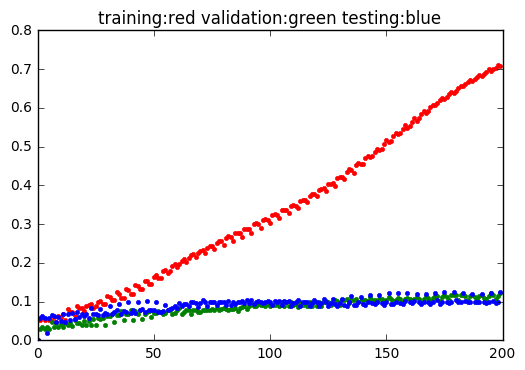

In [12]:
plt.plot(precision_history_on_training, 'r.')
plt.plot(precision_history_on_validation, 'g.')
plt.plot(precision_history_on_testing, 'b.')
plt.title("training:red validation:green testing:blue")
plt.show()